In [2]:
from scipy.integrate import quad, trapz, fixed_quad
import theano
import theano.tensor as T
# from theano.tests.unittest_tools import verify_grad
from theano.compile.ops import as_op

import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord

from tqdm import tqdm

from gammapy.spectrum import CountsPredictor, CountsSpectrum
from gammapy.data import DataStore
from gammapy.maps import Map
from gammapy.background import ReflectedRegionsBackgroundEstimator
from gammapy.spectrum import SpectrumObservationList
from gammapy.data import DataStore
from gammapy.spectrum import SpectrumObservationList
from gammapy.maps import Map
from gammapy.background import ReflectedRegionsBackgroundEstimator
from gammapy.spectrum import SpectrumExtraction

from scipy.ndimage import filters 

from regions import CircleSkyRegion

from utils import load_spectrum_observations, plot_spectra, Log10Parabola, integrate_spectrum, wstat_profile
# from forward_fold_model import model_probability, ln_profile_likelihood

%matplotlib inline

In [3]:
import gammapy
gammapy.__version__

'0.10'

In [5]:
crab_position = SkyCoord(ra='83d37m59.0988s', dec='22d00m52.2s')
exclusion_map = Map.read(f"../data/exclusion_mask.fits.gz")

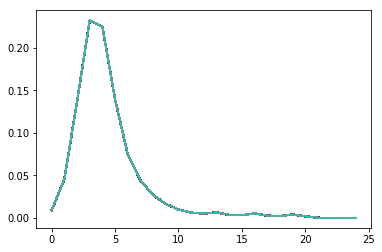

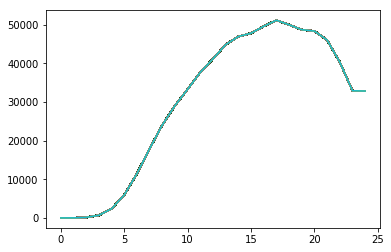

In [524]:
telescope = 'fact'

energy_range = {
    'fact': [1, 20] * u.TeV,
    'magic': [0.08, 30] * u.TeV,
    'veritas': [0.16, 30] * u.TeV,
    'hess': [0.4, 30] * u.TeV,
}

on_radius = {
    'fact': 0.17 * u.deg,
    'magic': 0.142 * u.deg,
    'veritas': 0.10 * u.deg,
    'hess': 0.11 * u.deg,
}
ds = DataStore.from_dir(f'../data/{telescope}/')
observations = ds.get_observations(ds.hdu_table['OBS_ID'].data)

for obs in observations:
    plt.plot(obs.edisp.data.data.value.mean(axis=0)[:, 0])
    
plt.figure()

for obs in observations:
    plt.plot(obs.aeff.data.data.value.mean(axis=1))

In [525]:
# fit_range = [0.6, 30] * u.TeV
fit_range = energy_range[telescope]
# print(fit_range)
e_true_bins = np.logspace(*np.log10(fit_range.value), 14 + 1)
# e_true_bins[0] = 0.0001 * u.TeV
# e_true_bins[-1] = 1000 * u.TeV
# e_true_bins = np.append(e_true_bins, 1000) 
e_reco_bins = np.logspace(*np.log10(fit_range.value), 18 + 1)
# e_reco_bins[0] = 0.0001 * u.TeV
# e_reco_bins = np.append(e_reco_bins, 1000) 

e_reco_bins *= u.TeV
e_true_bins *= u.TeV

e_reco_bins

<Quantity [ 1.        ,  1.18108035,  1.39495079,  1.64754897,  1.94588772,
            2.29824975,  2.71441762,  3.20594531,  3.78647901,  4.47213595,
            5.2819519 ,  6.2384096 ,  7.368063  ,  8.70227443, 10.27808533,
           12.13924462, 14.33742329, 16.93364892, 20.        ] TeV>

In [526]:
on_region = CircleSkyRegion(center=crab_position, radius=on_radius[telescope])

print('Estimating Background')
bkg_estimate = ReflectedRegionsBackgroundEstimator(
    observations=observations, on_region=on_region, exclusion_mask=exclusion_map
)
bkg_estimate.run()

print('Extracting Count Spectra')
extract = SpectrumExtraction(
    observations=observations,
    bkg_estimate=bkg_estimate.result,
    e_true=e_true_bins,
    e_reco=e_reco_bins,
    containment_correction=False,
    use_recommended_erange=False,
)

extract.run()


Estimating Background
Extracting Count Spectra


In [527]:
stacked_observation = extract.spectrum_observations.stack()

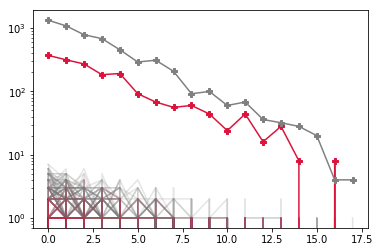

In [528]:
spectrum_observations = extract.spectrum_observations
# print(len(spectrum_observations))
for obs in spectrum_observations:
    plt.plot(obs.on_vector.data.data, color='crimson', alpha=0.05)
    plt.plot(obs.off_vector.data.data, color='gray', alpha=0.05)
    
# on_data, off_data = get_observed_counts(spectrum_observations)

# plt.plot(on_data, color='crimson')
# plt.plot(off_data, color='gray', )

plt.plot(stacked_observation.on_vector.data.data, color='crimson', marker='P' )
plt.plot(stacked_observation.off_vector.data.data, color='gray', marker='P')
plt.yscale('log')
# obs.on_vector.data.data.shape, obs.off_vector.data.data.shape

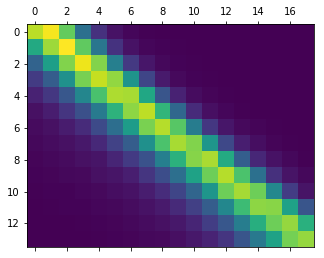

<Figure size 432x288 with 0 Axes>

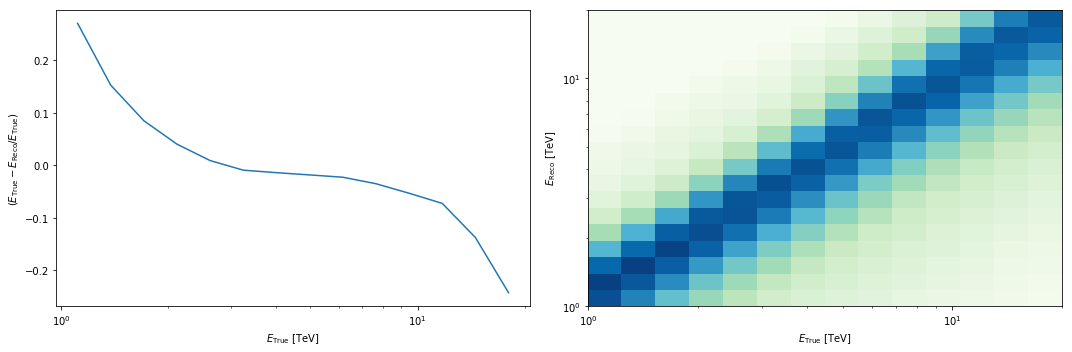

In [529]:
plt.matshow(stacked_observation.edisp.pdf_matrix)
plt.figure()
stacked_observation.edisp.peek()

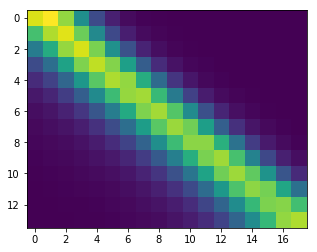

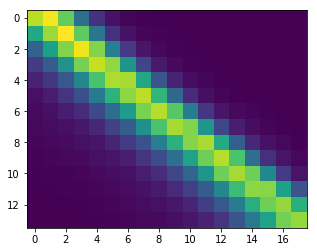

In [530]:
m = filters.gaussian_filter(stacked_observation.edisp.pdf_matrix, sigma=0.6)
plt.imshow(m)
plt.figure()
plt.imshow(stacked_observation.edisp.pdf_matrix)

In [531]:
def response(mu_sig, edisp, fit_range=None):
#     edisp = edisp.pdf_matrix
#     N, M = edisp.shape

#     a = filters.gaussian_filter(np.eye(M), sigma=1)
#     b = filters.gaussian_filter(np.eye(N), sigma=1)
    
#     edisp = ( 1 - epsilon) * edisp + epsilon * T.dot(edisp, a)
#     edisp = ( 1 - kappa) * edisp + kappa * T.dot(b, edisp)
    counts = T.dot(mu_sig, edisp)
    return counts

In [532]:
N_true = len(stacked_observation.edisp.e_true.lo)
N_reco = len(stacked_observation.edisp.e_reco.lo)

laplace_matrix = filters.laplace(np.eye(N_true)) // 2

def thikonov(f, normalize=False):
    if normalize:
        f = f/f.sum()
    a = T.dot(laplace_matrix, f)
    a_transposed = a.T 
    return T.dot(a, a_transposed)

In [533]:
def transform(mu_s, aeff):
    return pm.math.log(mu_s / aeff)

In [534]:
on_data = stacked_observation.on_vector.data.data.value
off_data = stacked_observation.off_vector.data.data.value

# t_on_data = theano.shared(on_data)
# t_off_data = theano.shared(off_data)

exposure_ratio = theano.shared(stacked_observation.alpha[0] )
aeff = theano.shared(stacked_observation.aeff.data.data.value)


m = filters.gaussian_filter(stacked_observation.edisp.pdf_matrix, sigma=0)
edisp = theano.shared(m)

N_true = len(stacked_observation.edisp.e_true.lo)
N_reco = len(stacked_observation.edisp.e_reco.lo)

tau=0.0

model = pm.Model(theano_config={'compute_test_value': 'ignore'})
with model:
    mu_b = pm.HalfFlat('mu_b', shape=len(off_data))
    mu_s = pm.HalfFlat('mu_s', shape=len(stacked_observation.edisp.e_true.lo))

#     tau = pm.HalfNormal('tau', sd=5)
#     mu_b = pm.TruncatedNormal('mu_b', sd=20, shape=len(off_data), lower=0)
#     mu_s = pm.TruncatedNormal('mu_s', sd=5, shape=len(stacked_observation.edisp.e_true.lo), lower=0)
#     epsilon = pm.Normal('epsilon', sd=0.015, mu=0)
#     kappa = pm.Normal('kappa', sd=0.015, mu=0)
    expected_counts = response(mu_s, edisp=edisp)
    
    if tau > 0.0:
        lam = thikonov(transform(mu_s, aeff))
        logp = pm.Normal.dist(mu=0, sd=1/tau).logp(lam) 
        p = pm.Potential("thikonov", logp)    


    #     print(expected_counts.shape)
    b = pm.Poisson('background', mu=mu_b, observed=off_data)    
    s = pm.Poisson('signal', mu = expected_counts + exposure_ratio * mu_b, observed=on_data)
    

In [535]:
with model:
#     step1 = pm.Metropolis([mu_b])
#     step2 = pm.NUTS([amplitude, alpha, beta], target_accept=0.9)
#     trace = pm.sample(1000, step=[step1, step2], chains=5, cores=5)
    trace = pm.sample(1500, chains=6, cores=6, init='advi+adapt_diag', target_accept=0.9, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 229.85:  18%|█▊        | 36008/200000 [00:13<01:00, 2700.96it/s] 
Convergence achieved at 36300
Interrupted at 36,299 [18%]: Average Loss = 9,726.8
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [mu_s, mu_b]
Sampling 6 chains: 100%|██████████| 27000/27000 [00:16<00:00, 1672.89draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7051051734098253, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x170e7ffd0>,
      dtype=object)

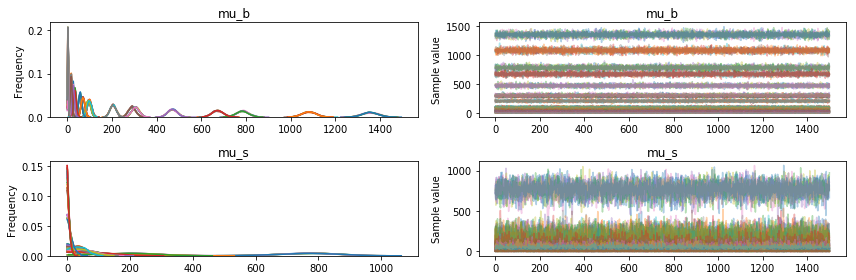

In [536]:
pm.traceplot(trace)

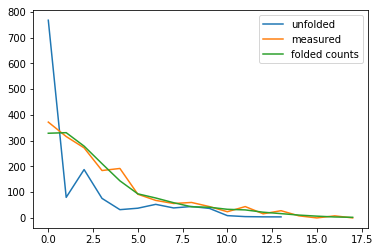

In [537]:
exposure_ratio = stacked_observation.alpha[0]

f = np.median(trace['mu_s'], axis=0)
b = np.median(trace['mu_b'], axis=0)
plt.plot(f, label='unfolded')

expected_counts = np.dot(f, stacked_observation.edisp.pdf_matrix)
plt.plot(on_data, label='measured')
plt.plot(expected_counts + exposure_ratio*b, label='folded counts')
plt.legend()

[2.53995457e-12 5.57255529e-12 1.19779585e-12 3.37399587e-13
 3.05300948e-13 3.57008374e-13 1.78564830e-13 1.72350617e-13
 1.26040542e-13 1.75212095e-14 8.14081543e-15 5.49911348e-15] [5.66746182e-12 8.95613657e-12 2.57534079e-12 7.78426563e-13
 6.80145857e-13 6.94902679e-13 3.86300488e-13 3.45863327e-13
 2.23642367e-13 4.12512099e-14 1.85519085e-14 1.20883598e-14] [1.05342940e-11 1.20514512e-11 4.31219464e-12 1.40918215e-12
 1.18664579e-12 1.08214066e-12 6.57651157e-13 5.41098756e-13
 3.31188531e-13 7.68782804e-14 3.41598390e-14 2.25015527e-14]


Text(0.5, 1.0, 'fact')

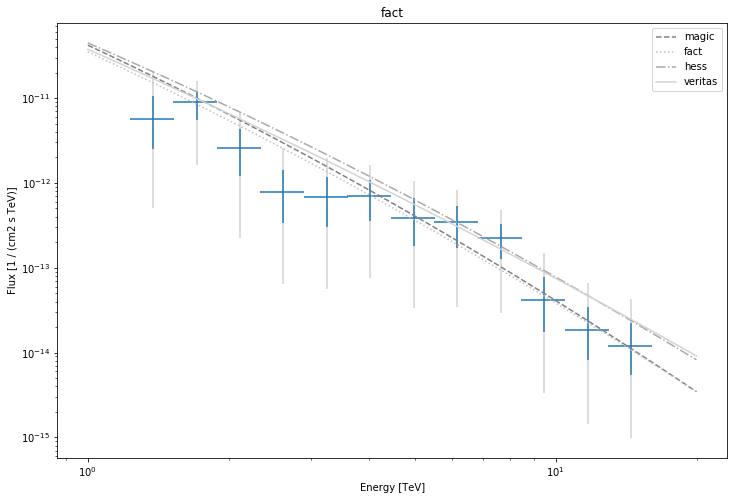

In [538]:
observation = stacked_observation

magic_model = Log10Parabola(
    amplitude=4.20 * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    alpha=2.58 * u.Unit(''),
    beta=0.43 * u.Unit(''),
)

fact_model = Log10Parabola(
    amplitude=3.5 * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    alpha=2.56* u.Unit(''),
    beta=0.4 * u.Unit(''),
)

hess_model = Log10Parabola(
    amplitude=4.47 * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    alpha=2.39* u.Unit(''),
    beta=0.37 * u.Unit(''),
)

veritas_model = Log10Parabola(
    amplitude=3.76 * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    alpha=2.44 * u.Unit(''),
    beta=0.26 * u.Unit(''),
)


e_center = stacked_observation.edisp.e_true.log_center().to_value(u.TeV)[1:-1]
bin_width = stacked_observation.edisp.e_true.bin_width.to_value(u.TeV)[1:-1]

norm = 1 / stacked_observation.aeff.data.data / stacked_observation.livetime / stacked_observation.edisp.e_true.bin_width
norm = norm[1:-1]
flux = trace['mu_s'][:, 1:-1] * norm
mean_flux = np.median(flux, axis=0).to_value(1 / (u.TeV * u.s * u.cm**2))
lower, upper = np.percentile(flux, [25, 75], axis=0)
lower_95, upper_95 = np.percentile(flux, [5, 95], axis=0)

dl = mean_flux - lower
du = upper - mean_flux
print(lower, mean_flux, upper)

# # flux = s * observation.edisp.e_true.log_center()**2
# # mle_model.plot(energy_range=fit_range, ls='--', color='red', label='magic paper', energy_power=2)
# # plt.plot(e_center, flux.to_value(u.TeV / (u.s * u.cm**2)), '.')

# # plt.figure()
# # flux = s * observation.edisp.e_true.log_center()**1
# # mle_model.plot(energy_range=fit_range, ls='--', color='red', label='magic paper', energy_power=1)
# # plt.plot(e_center, flux.to_value(1 / (u.s * u.cm**2)), '.')

plt.figure(figsize=(12, 8))
magic_model.plot(energy_range=fit_range, ls='--', color='gray', label='magic')
fact_model.plot(energy_range=fit_range, ls=':', color='silver', label='fact')
hess_model.plot(energy_range=fit_range, ls='-.', color='darkgray', label='hess')
veritas_model.plot(energy_range=fit_range, ls='-', color='lightgray', label='veritas')
# plt.plot(e_center, flux.to_value(1 / (u.TeV * u.s * u.cm**2)), '.')

dl = mean_flux - lower_95
du = upper_95 - mean_flux
plt.errorbar(e_center, mean_flux, yerr=[dl, du],  linestyle='', color='lightgray')

dl = mean_flux - lower
du = upper - mean_flux
plt.errorbar(e_center, mean_flux, yerr=[dl, du],  xerr=bin_width/2, linestyle='')



plt.legend()
plt.title(telescope)
# plt.figure(figsize=(10, 3))
# plt.plot(lower)
# plt.plot(upper)
# plt.yscale('log')


# plt.figure(figsize=(10, 3))
# plt.plot(np.std(trace['mu_s'], axis=0)[1:-1] * norm)
# # plt.yscale('log')

# observation.edisp.e_true.log_center()

In [539]:
with model:
    samples = pm.sample_posterior_predictive(trace, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1682.36it/s]


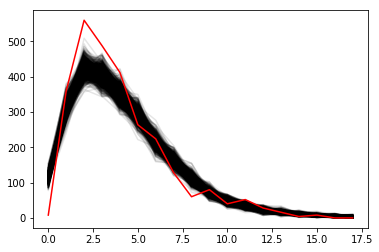

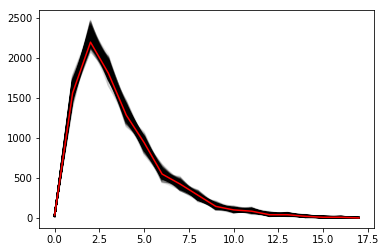

In [523]:
plt.figure()
plt.plot(samples['signal'].T, color='k', alpha=0.1)
plt.plot(on_data , color='red')

plt.figure()
plt.plot(samples['background'].T, color='k', alpha=0.1)
plt.plot(off_data, color='red')

None

Text(0.5, 0.98, 'background')

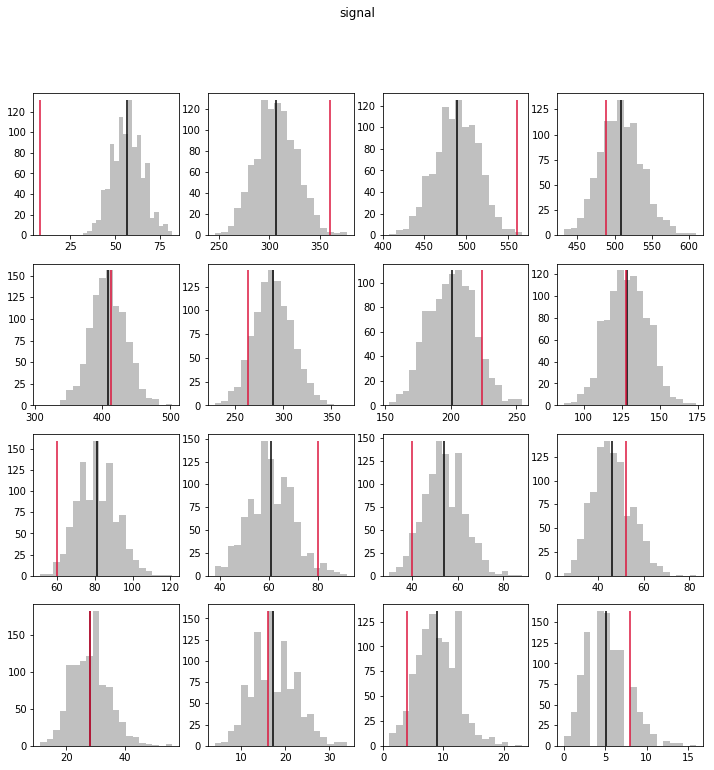

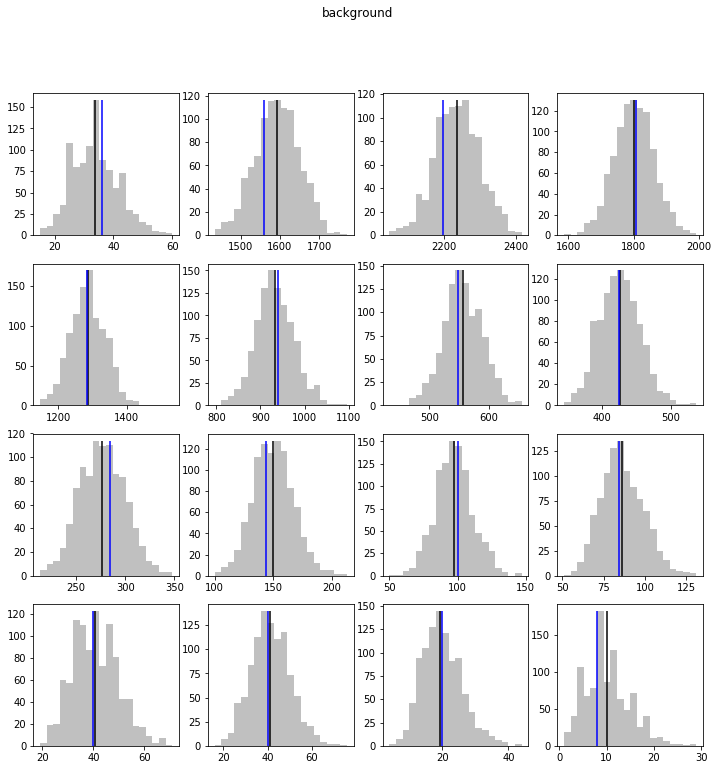

In [495]:
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for s, on, ax in zip(samples['signal'].T, on_data, axs.ravel()):
    h, _,_ =  ax.hist(s, bins=20, lw=2, color='silver')
    ax.vlines(s.mean(), ymin=0, ymax=h.max())
    ax.vlines(on, ymin=0, ymax=h.max(), color='crimson')
fig.suptitle('signal')
    
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for s, off, ax in zip(samples['background'].T, off_data, axs.ravel()):
    h, _,_ =  ax.hist(s, bins=20, lw=2, color='silver')
    ax.vlines(s.mean(), ymin=0, ymax=h.max())
    ax.vlines(off, ymin=0, ymax=h.max(), color='blue')
fig.suptitle('background')

In [496]:
# display the total number and percentage of divergent
divergent = trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(trace) * 100
print('Percentage of Divergent %.1f' % divperc)

Number of Divergent 28
Percentage of Divergent 1.9


In [497]:
pm.summary(trace).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_b__0,33.778999,5.442000,0.051,23.500,44.669,9240.404,1.000
mu_b__1,1593.425049,39.325001,0.366,1517.281,1670.413,10169.290,1.000
mu_b__2,2233.012939,45.848999,0.539,2144.419,2323.786,8657.092,1.000
mu_b__3,1801.897949,41.698002,0.405,1724.091,1885.161,9725.113,1.000
mu_b__4,1286.072021,35.784000,0.355,1217.524,1356.943,8734.306,1.000
mu_b__5,931.549011,30.103001,0.298,873.605,992.667,8934.791,1.000
mu_b__6,556.520020,23.479000,0.239,509.631,601.563,9039.356,1.000
mu_b__7,424.841003,20.028000,0.199,386.629,465.309,9544.332,1.000
mu_b__8,276.977997,16.270000,0.176,245.610,309.177,9435.423,1.000
mu_b__9,150.460007,12.424000,0.123,126.161,174.492,8553.314,1.000
